<div class="alert alert-block alert-success" style="font-size:30px">
🦴 [train] PyTorch-EfficientNetV2 baseline CV:0.49 🦴
</div>

<div class="alert alert-block alert-danger" style="text-align:center; font-size:20px;">
    ❤️ Dont forget to ▲upvote▲ if you find this notebook usefull!  ❤️
</div>

<div class="alert alert-block alert-info">
    <ul>
        <li>
            📌 This is a training part. For <b>inference</b> refer to: <a href="https://www.kaggle.com/code/vslaykovsky/infer-pytorch-effnetv2-single-model-pl-0-49">Pytorch EfficientNet-v2 single model PL:0.49, ensemble PL:0.47</a>
        </li>
        <li>
            📌 Note that this notebook depends on <b>vertebrae detection dataset</b>. Check it out here: <a href="https://www.kaggle.com/code/vslaykovsky/pytorch-effnetv2-vertebrae-detection-acc-0-95">PyTorch-EffNetV2 vertebrae detection (acc: 0.95)</a>
        </li>
        <li>
            📌 To run the notebook in non-interactive mode, <b>set Add-ons->Secrets->WANDB_API_KEY</b> secret key to the value of your <a href="https://wandb.ai/authorize">Wandb API key. </a>
        </li>        
</div>


This is a bare-bones PyTorch implementation of EfficientNet-v2 based classifier. This is a simple baseline implementation that can be iteratively improved.


<img src="https://images2.imgbox.com/cd/58/AeY81v9Y_o.png" alt="image host"/>


Here is the high level overview of the training flow:
1. Images are loaded from train folder and transformed to `3x384x384` tensors using the same transformations used to pretrain `EfficientNet_V2_S` on ImageNet 1000.
2. Images are passed to a pre-trained encoder of `EfficientNet_V2_S`. We ignore the final classification layer of the `EfficientNet_V2_S`, because it's shape is irrelevant given the current task. The most valuable layer of `EfficientNet_V2_S` that we'll use as a base for our final classification layer is the flattened (1280,) layer. (1280,) is then transformed to 2 parallel (7,) `Linear` layers followed by a sigmoid nonlinearity. Note that we use logits in the loss function to improve numerical stability.
3. Vertebrae fracture targets are loaded from `train.csv` file. Vertebrae detection targets are loaded from `train_segmented.csv` which comes from <a href="https://www.kaggle.com/code/vslaykovsky/pytorch-effnetv2-vertebrae-detection-acc-0-95">PyTorch-EffNetV2 vertebrae detection (acc: 0.95)</a>. We only predict fractures that are visible on the current slice by masking fracture targets with visible vertebrae targets. Visible vertebrae targets are passed to the loss function as is without modifications.
4. Predictions and targets are passed to BCELoss which is a muti-label loss function that optimizes 7 independent binary classification targets for C1-C7. Don't confuse this with the multiclass crossentropy loss. Additionally, we implement weighted loss for fracture targets.
5. In the end we get a model that detects fractures and visible C1-C7 vertebrae using a single image. We need to figure out how to estimate the final result with 1 record per StudyInstanceUID, rather than 1 record per scan. We use a non-parametric model to combine predictions of base models:    
    * For each StudyInstanceUID we first aggregate predictions for each of C1-C7 vertebrae by weighted averaging fracture predictions. Probabilities of vertebrae are used as weights. Example: if we are uncertain that C3 is in the slice (`C3_effnet_vert==0.1`), but we somehow predict high probability of C3 being fractured (`C3_effnet_frac==0.9`), we add it to the final aggregate with low weight `0.9 * 0.1 == 0.09`
    * We use a simple probability formula to derive `patient_overall` fracture probability. `patient_overall` is a probability of any vertebrae being fractured. It is equal to `1-no-vertebrae-are-fractured`. Under assumption of independence of vertebrae fractures we can derive the following simple equation: $P_{\text{patient_overall}}=1-\prod_i{[1-C_i]}$



### Ideas implemented in this notebook

1. Decoding **JPEG-encoded scans** along with regular scans to increase the size of training set.

2. **Train-eval splitting based on patient id** (StudyInstanceUID). Using GroupKFold with patient id as a group id. This makes evaluation result more accurate as there is significant correlation between close scans from the same patient.

3. **Weighted loss optimization.**. Adjusting weights of classes to optimize the same loss function as the one used in scoring of the solution.


$$
L_{ij} = - w_j \left(y_{ij} \log(p_{ij}) + (1-y_{ij}) \log(1-p_{ij})  \right)
$$

where the **weights** [are given by](https://www.kaggle.com/competitions/rsna-2022-cervical-spine-fracture-detection/discussion/340392)

$$
w_{j} = \begin{cases}
1, \qquad \text{if vertebrae negative} \\
2, \qquad \text{if vertebrae positive} \\
7, \qquad \text{if patient negative} \\
14, \qquad \text{if patient positive}
\end{cases}
$$
Note, that the base EfficientNet-v2 model only uses the first two weights.

4. **Accurate loss evaluation**. Evaluation using the same exact loss function used in scoring of the final solution.

5. **OneCycleLR**. OneCyleLR is often the best choice of scheduler with limited compute. Read more about it here: https://sgugger.github.io/the-1cycle-policy.html

![45YUYb.md.png](https://iili.io/45YUYb.md.png)

6. **Mixed-precision** training with gradient scaling is implemented to speed up training on Nvidia Ampere architectures.

7. Using **Wandb** for logging.

8. Removed "1.2.826.0.1.3680043.20574" https://www.kaggle.com/competitions/rsna-2022-cervical-spine-fracture-detection/discussion/344862

9. Training data is **subsampled**. E.g. we don't use all 100% samples here to avoid overfitting. To reduce overfitting try adding augmentations/regularization to your pipeline.

<div class="alert alert-block alert-success" style="font-size:25px">
🦴 1. Imports, constants, dependencies 🦴
</div>

In [1]:
try:
    import pylibjpeg
except:
    # The following *.whl files were collected from these pip packages:
    #!pip install -U "python-gdcm" pydicom pylibjpeg    # Required for JPEG decompression. See: https://www.kaggle.com/competitions/rsna-2022-cervical-spine-fracture-detection/discussion/341412
    #!pip install -U torchvision                        # For EfficientNetV2

    # Offline dependencies:
    !mkdir -p /root/.cache/torch/hub/checkpoints/
    !cp ../input/rsna-2022-whl/efficientnet_v2_s-dd5fe13b.pth  /root/.cache/torch/hub/checkpoints/
    !pip install /kaggle/input/rsna-2022-whl/{pydicom-2.3.0-py3-none-any.whl,pylibjpeg-1.4.0-py3-none-any.whl,python_gdcm-3.0.15-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl}
    !pip install /kaggle/input/rsna-2022-whl/{torch-1.12.1-cp37-cp37m-manylinux1_x86_64.whl,torchvision-0.13.1-cp37-cp37m-manylinux1_x86_64.whl}

In [2]:
import gc
import glob
import os
import re

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydicom as dicom
import torch
import torchvision as tv
from sklearn.model_selection import GroupKFold,StratifiedKFold
from torch.cuda.amp import GradScaler, autocast
from torchvision.models.feature_extraction import create_feature_extractor
from tqdm.notebook import tqdm

import wandb

plt.rcParams['figure.figsize'] = (20, 5)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 1000)

# Effnet
WEIGHTS = tv.models.efficientnet.EfficientNet_V2_S_Weights.DEFAULT
RSNA_2022_PATH = '../input/rsna-2022-cervical-spine-fracture-detection'
TRAIN_IMAGES_PATH = f'{RSNA_2022_PATH}/train_images'
TEST_IMAGES_PATH = f'{RSNA_2022_PATH}/test_images'
EFFNET_MAX_TRAIN_BATCHES = 18000
EFFNET_MAX_EVAL_BATCHES = 200
ONE_CYCLE_MAX_LR = 0.00008
ONE_CYCLE_PCT_START = 0.3
SAVE_CHECKPOINT_EVERY_STEP = 3000
EFFNET_CHECKPOINTS_PATH = '../output/ckpt-v2'
FRAC_LOSS_WEIGHT = 0.2
N_FOLDS = 5
METADATA_PATH = '../input/vertebrae-detection-checkpoints'

PREDICT_MAX_BATCHES = 1e9

# Common
try:
    from kaggle_secrets import UserSecretsClient
    IS_KAGGLE = True
except:
    IS_KAGGLE = False

os.environ["WANDB_MODE"] = "online"
if os.environ["WANDB_MODE"] == "online":
    if IS_KAGGLE:
        os.environ['WANDB_API_KEY'] = UserSecretsClient().get_secret("WANDB_API_KEY")

if not IS_KAGGLE:
    print('Running locally')
    RSNA_2022_PATH = '../input/rsna-2022-cervical-spine-fracture-detection'
    TRAIN_IMAGES_PATH = '../input/rsna-2022-cervical-spine-fracture-detection/train_images'
    TEST_IMAGES_PATH = '../input/rsna-2022-cervical-spine-fracture-detection/test_images'
    METADATA_PATH = r'W:\PycharmProjects\kaggle-RSNA\input\rsna-2022-spine-fracture-detection-metadata'
    EFFNET_CHECKPOINTS_PATH = 'frac_checkpoints'
    os.environ['WANDB_API_KEY'] = '38c8eb6b3d0a6b9221c841d0d67ca44a78c4190e'

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
if DEVICE == 'cuda':
    BATCH_SIZE = 32
else:
    BATCH_SIZE = 2


Running locally


<div class="alert alert-block alert-success" style="font-size:25px">
    🦴 2. Loading train/eval/test dataframes 🦴
</div>

### Train data

1. Loading data from competition dataset folder `../input/rsna-2022-cervical-spine-fracture-detection/train.csv`
2. Joining data with slice information from metadata dataset `../input/rsna-2022-spine-fracture-detection-metadata/meta_train_with_vertebrae.csv`
3. Adding `Splits` column to facilitate train/eval splits.

In [3]:
df_train = pd.read_csv(f'{RSNA_2022_PATH}/train.csv')
df_train.sample(2)

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
1192,1.2.826.0.1.3680043.28547,1,0,1,0,0,0,0,0
189,1.2.826.0.1.3680043.15623,1,1,0,0,0,0,0,0


In [4]:
# rsna-2022-spine-fracture-detection-metadata contains inference of C1-C7 vertebrae for all training sample (95% accuracy)
df_train_slices = pd.read_csv(f'{METADATA_PATH}/train_segmented.csv')
c1c7 = [f'C{i}' for i in range(1, 8)]
df_train_slices[c1c7] = (df_train_slices[c1c7] > 0.5).astype(int)
print(df_train_slices.sample(5)[['StudyInstanceUID', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']].to_markdown())

|        | StudyInstanceUID          |   C1 |   C2 |   C3 |   C4 |   C5 |   C6 |   C7 |
|-------:|:--------------------------|-----:|-----:|-----:|-----:|-----:|-----:|-----:|
| 440069 | 1.2.826.0.1.3680043.28321 |    0 |    0 |    0 |    0 |    0 |    1 |    1 |
| 440081 | 1.2.826.0.1.3680043.28321 |    0 |    0 |    0 |    0 |    0 |    0 |    1 |
| 551995 | 1.2.826.0.1.3680043.3376  |    0 |    0 |    0 |    0 |    1 |    1 |    0 |
| 659110 | 1.2.826.0.1.3680043.7673  |    0 |    0 |    0 |    0 |    0 |    0 |    0 |
| 485839 | 1.2.826.0.1.3680043.30213 |    0 |    1 |    0 |    0 |    0 |    0 |    0 |


In [5]:
df_train = df_train_slices.set_index('StudyInstanceUID').join(df_train.set_index('StudyInstanceUID'),
                                                              rsuffix='_fracture').reset_index().copy()
df_train = df_train.query('StudyInstanceUID != "1.2.826.0.1.3680043.20574"').reset_index(drop=True)
df_train.sample(2)

,StudyInstanceUID,Slice,ImageHeight,ImageWidth,SliceThickness,ImagePositionPatient_x,ImagePositionPatient_y,ImagePositionPatient_z,C1,C2,C3,C4,C5,C6,C7,patient_overall,C1_fracture,C2_fracture,C3_fracture,C4_fracture,C5_fracture,C6_fracture,C7_fracture
513813,1.2.826.0.1.3680043.31351,92,512,512,1.0,-62.360352,-263.860352,379.5,0,1,1,0,0,0,0,1,0,0,0,0,1,1,0
203221,1.2.826.0.1.3680043.18786,310,512,512,0.5,-62.343600,-60.390470,1788.4,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1


In [6]:
split = StratifiedKFold(N_FOLDS)
for k, (_, test_idx) in enumerate(split.split(df_train, groups=df_train.StudyInstanceUID)):
    df_train.loc[test_idx, 'split'] = k
df_train.sample(2)

,StudyInstanceUID,Slice,ImageHeight,ImageWidth,SliceThickness,ImagePositionPatient_x,ImagePositionPatient_y,ImagePositionPatient_z,C1,C2,C3,C4,C5,C6,C7,patient_overall,C1_fracture,C2_fracture,C3_fracture,C4_fracture,C5_fracture,C6_fracture,C7_fracture,split
705402,1.2.826.0.1.3680043.9548,422,512,512,0.5,-79.92172,-51.60141,1872.600000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
396365,1.2.826.0.1.3680043.2645,132,512,512,1.0,-76.00000,35.00000,220.400024,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0


### Test data

1. Loading data from competition dataset folder `../input/rsna-2022-cervical-spine-fracture-detection/test.csv`
2. Joining data with slice information collected from test image folders `../input/rsna-2022-cervical-spine-fracture-detection/test_images/*/*`

In [7]:
df_test = pd.read_csv(f'{RSNA_2022_PATH}/test.csv')

if df_test.iloc[0].row_id == '1.2.826.0.1.3680043.10197_C1':
    # test_images and test.csv are inconsistent in the dev dataset, fixing labels for the dev run.
    df_test = pd.DataFrame({
        "row_id": ['1.2.826.0.1.3680043.22327_C1', '1.2.826.0.1.3680043.25399_C1', '1.2.826.0.1.3680043.5876_C1'],
        "StudyInstanceUID": ['1.2.826.0.1.3680043.22327', '1.2.826.0.1.3680043.25399', '1.2.826.0.1.3680043.5876'],
        "prediction_type": ["C1", "C1", "patient_overall"]}
    )

df_test

,row_id,StudyInstanceUID,prediction_type
0,1.2.826.0.1.3680043.22327_C1,1.2.826.0.1.3680043.22327,C1
1,1.2.826.0.1.3680043.25399_C1,1.2.826.0.1.3680043.25399,C1
2,1.2.826.0.1.3680043.5876_C1,1.2.826.0.1.3680043.5876,patient_overall


In [8]:
# test_slices = glob.glob(f'{TEST_IMAGES_PATH}/*/*')
# test_slices = [re.findall(f'{TEST_IMAGES_PATH}/(.*)/(.*).dcm', s)[0] for s in test_slices]
# df_test_slices = pd.DataFrame(data=test_slices, columns=['StudyInstanceUID', 'Slice'])
# df_test_slices.sample(2)

In [9]:
# df_test = df_test.set_index('StudyInstanceUID').join(df_test_slices.set_index('StudyInstanceUID')).reset_index()
# df_test.sample(2)

<div class="alert alert-block alert-success" style="font-size:25px">
    🦴 3. Dataset class 🦴
</div>

`EffnetDataSet` class returns images of individual slices. It uses a dataframe parameter `df` as a source of slices metadata to locate and load images from `path` folder. It accepts transforms parameter which we set to `WEIGHTS.transforms()`. This is a set of transforms used to pre-train the model on ImageNet dataset.

Text(0.5, 1.0, 'jpeg')

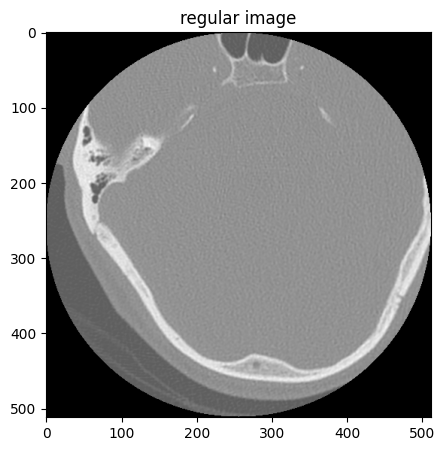

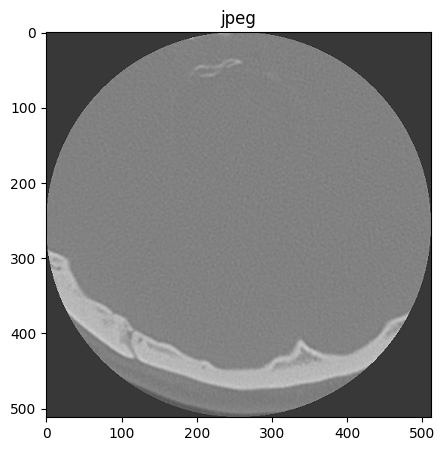

In [10]:
def load_dicom(path):
    """
    This supports loading both regular and compressed JPEG images. 
    See the first sell with `pip install` commands for the necessary dependencies
    """
    img = dicom.dcmread(path)
    img.PhotometricInterpretation = 'YBR_FULL'
    data = img.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return cv2.cvtColor(data, cv2.COLOR_GRAY2RGB), img


im, meta = load_dicom(
    f'{TRAIN_IMAGES_PATH}/1.2.826.0.1.3680043.10001/1.dcm')
plt.figure()
plt.imshow(im)
plt.title('regular image')

im, meta = load_dicom(
    f'{TRAIN_IMAGES_PATH}/1.2.826.0.1.3680043.10014/1.dcm')
plt.figure()
plt.imshow(im)
plt.title('jpeg')

In [11]:
class EffnetDataSet(torch.utils.data.Dataset):
    def __init__(self, df, path, transforms=None):
        super().__init__()
        self.df = df
        self.path = path
        self.transforms = transforms

    def __getitem__(self, i):
        path = os.path.join(self.path, self.df.iloc[i].StudyInstanceUID, f'{self.df.iloc[i].Slice}.dcm')

        try:
            img = load_dicom(path)[0]
            # Pytorch uses (batch, channel, height, width) order. Converting (height, width, channel) -> (channel, height, width)
            img = np.transpose(img, (2, 0, 1))
            if self.transforms is not None:
                img = self.transforms(torch.as_tensor(img))
        except Exception as ex:
            print(ex)
            return None

        if 'C1_fracture' in self.df:
            frac_targets = torch.as_tensor(self.df.iloc[i][['C1_fracture', 'C2_fracture', 'C3_fracture', 'C4_fracture',
                                                            'C5_fracture', 'C6_fracture', 'C7_fracture']].astype(
                'float32').values)
            vert_targets = torch.as_tensor(
                self.df.iloc[i][['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']].astype('float32').values)
            frac_targets = frac_targets * vert_targets  # we only enable targets that are visible on the current slice
            return img, frac_targets, vert_targets
        return img

    def __len__(self):
        return len(self.df)


In [12]:
ds_train = EffnetDataSet(df_train, TRAIN_IMAGES_PATH, WEIGHTS.transforms())
X, y_frac, y_vert = ds_train[42]
print(X.shape, y_frac.shape, y_vert.shape)

torch.Size([3, 384, 384]) torch.Size([7]) torch.Size([7])


In [13]:
# def plot_sample_patient(df, ds):
#     patient = np.random.choice(df.query('patient_overall > 0').StudyInstanceUID)
#     df = df.query('StudyInstanceUID == @patient')
#     # display(df)
#
#     frac = np.stack([ds[i][1] for i in df.index])
#     vert = np.stack([ds[i][2] for i in df.index])
#     ax = plt.subplot(1, 2, 1)
#     ax.plot(frac)
#     ax.set_title(f'Vertebrae with fractures by slice (masked by visible vertebrae). uid:{patient}')
#     ax = plt.subplot(1, 2, 2)
#     ax.set_title(f'Visible vertebrae by slice. uid:{patient}')
#     ax.plot(vert)
#
# plot_sample_patient(df_train, ds_train)

In [14]:
# # Only X values returned by the test dataset
# ds_test = EffnetDataSet(df_test, TEST_IMAGES_PATH, WEIGHTS.transforms())
# X = ds_test[42]
# X.shape

<div class="alert alert-block alert-success" style="font-size:25px">
    🦴 4. Model 🦴
</div>


In Pytorch we use create_feature_extractor to access feature layers of pre-existing models. Final flat layer of `efficientnet_v2_s` model is called `flatten`. We'll build our classification layer on top of it. 

In [15]:
class EffnetModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        effnet = tv.models.efficientnet_v2_s(weights=WEIGHTS)
        self.model = create_feature_extractor(effnet, ['flatten'])
        self.nn_fracture = torch.nn.Sequential(
            torch.nn.Linear(1280, 7),
        )
        self.nn_vertebrae = torch.nn.Sequential(
            torch.nn.Linear(1280, 7),
        )

    def forward(self, x):
        # returns logits
        x = self.model(x)['flatten']
        return self.nn_fracture(x), self.nn_vertebrae(x)

    def predict(self, x):
        frac, vert = self.forward(x)
        return torch.sigmoid(frac), torch.sigmoid(vert)

model = EffnetModel()
model.predict(torch.randn(1, 3, 512, 512))
del model

<div class="alert alert-block alert-success" style="font-size:25px">
    🦴 5.1 Train: loss function 🦴
</div>

We use weighted loss here. See definition here: https://www.kaggle.com/competitions/rsna-2022-cervical-spine-fracture-detection/discussion/340392
Weighted loss helps us to optimize the same target that is used in the final scoring.

Auxiliary vertebrae detection loss is added in the training/evaluation loop to improve model's performance.

In [16]:
def weighted_loss(y_pred_logit, y, reduction='mean', verbose=False):
    """
    Weighted loss
    We reuse torch.nn.functional.binary_cross_entropy_with_logits here. pos_weight and weights combined give us necessary coefficients described in https://www.kaggle.com/competitions/rsna-2022-cervical-spine-fracture-detection/discussion/340392

    See also this explanation: https://www.kaggle.com/code/samuelcortinhas/rsna-fracture-detection-in-depth-eda/notebook
    """

    neg_weights = (torch.tensor([7., 1, 1, 1, 1, 1, 1, 1]) if y_pred_logit.shape[-1] == 8 else torch.ones(y_pred_logit.shape[-1])).to(DEVICE)
    pos_weights = (torch.tensor([14., 2, 2, 2, 2, 2, 2, 2]) if y_pred_logit.shape[-1] == 8 else torch.ones(y_pred_logit.shape[-1]) * 2.).to(DEVICE)

    loss = torch.nn.functional.binary_cross_entropy_with_logits(
        y_pred_logit,
        y,
        reduction='none',
    )

    if verbose:
        print('loss', loss)

    pos_weights = y * pos_weights.unsqueeze(0)
    neg_weights = (1 - y) * neg_weights.unsqueeze(0)
    all_weights = pos_weights + neg_weights

    if verbose:
        print('all weights', all_weights)

    loss *= all_weights
    if verbose:
        print('weighted loss', loss)

    norm = torch.sum(all_weights, dim=1).unsqueeze(1)
    if verbose:
        print('normalization factors', norm)

    loss /= norm
    if verbose:
        print('normalized loss', loss)

    loss = torch.sum(loss, dim=1)
    if verbose:
        print('summed up over patient_overall-C1-C7 loss', loss)

    if reduction == 'mean':
        return torch.mean(loss)
    return loss

In [17]:
# Quick test of  patient_overall + C1-C7 loss
weighted_loss(
    torch.logit(torch.tensor([
        [0.1, 0.9, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
        [0.1, 0.9, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
    ])).to(DEVICE),
    torch.tensor([
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0, 0., 0., 0., 0., 0., 0.]
    ]).to(DEVICE),
    reduction=None,
    verbose=True
)

loss tensor([[2.3026, 0.1054, 0.1054, 0.1054, 0.1054, 0.1054, 0.1054, 0.1054],
        [0.1054, 2.3026, 0.1054, 0.1054, 0.1054, 0.1054, 0.1054, 0.1054]],
       device='cuda:0')
all weights tensor([[14.,  2.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 7.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]], device='cuda:0')
weighted loss tensor([[32.2362,  0.2107,  0.1054,  0.1054,  0.1054,  0.1054,  0.1054,  0.1054],
        [ 0.7375,  2.3026,  0.1054,  0.1054,  0.1054,  0.1054,  0.1054,  0.1054]],
       device='cuda:0')
normalization factors tensor([[22.],
        [14.]], device='cuda:0')
normalized loss tensor([[1.4653, 0.0096, 0.0048, 0.0048, 0.0048, 0.0048, 0.0048, 0.0048],
        [0.0527, 0.1645, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075]],
       device='cuda:0')
summed up over patient_overall-C1-C7 loss tensor([1.5036, 0.2623], device='cuda:0')


tensor([1.5036, 0.2623], device='cuda:0')

In [18]:
# Quick test of C1-C7 loss
weighted_loss(
    torch.logit(torch.tensor([
        [0.9, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
        [0.9, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
    ])).to(DEVICE),
    torch.tensor([
        [1., 0., 0., 0., 0., 0., 0.],
        [0, 0., 0., 0., 0., 0., 0.]
    ]).to(DEVICE),
    reduction=None,
    verbose=True
)

loss tensor([[0.1054, 0.1054, 0.1054, 0.1054, 0.1054, 0.1054, 0.1054],
        [2.3026, 0.1054, 0.1054, 0.1054, 0.1054, 0.1054, 0.1054]],
       device='cuda:0')
all weights tensor([[2., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1.]], device='cuda:0')
weighted loss tensor([[0.2107, 0.1054, 0.1054, 0.1054, 0.1054, 0.1054, 0.1054],
        [2.3026, 0.1054, 0.1054, 0.1054, 0.1054, 0.1054, 0.1054]],
       device='cuda:0')
normalization factors tensor([[8.],
        [7.]], device='cuda:0')
normalized loss tensor([[0.0263, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132],
        [0.3289, 0.0151, 0.0151, 0.0151, 0.0151, 0.0151, 0.0151]],
       device='cuda:0')
summed up over patient_overall-C1-C7 loss tensor([0.1054, 0.4192], device='cuda:0')


tensor([0.1054, 0.4192], device='cuda:0')

<div class="alert alert-block alert-success" style="font-size:25px">
    🦴 5.2 Train: training/evaluation loop 🦴
</div>

In [19]:
def filter_nones(b):
    return torch.utils.data.default_collate([v for v in b if v is not None])

In [20]:
def save_model(name, model):
    torch.save(model.state_dict(), f'{name}.tph')

In [21]:
def load_model(model, name, path='.'):
    data = torch.load(os.path.join(path, f'{name}.tph'), map_location=DEVICE)
    model.load_state_dict(data)
    return model


# quick test
model = torch.nn.Linear(2, 1)
save_model('testmodel', model)

model1 = load_model(torch.nn.Linear(2, 1), 'testmodel')
assert torch.all(
    next(iter(model1.parameters())) == next(iter(model.parameters()))
).item(), "Loading/saving is inconsistent!"

In [22]:
def evaluate_effnet(model: EffnetModel, ds, max_batches=PREDICT_MAX_BATCHES, shuffle=False):
    torch.manual_seed(42)
    model = model.to(DEVICE)
    dl_test = torch.utils.data.DataLoader(ds, batch_size=BATCH_SIZE, shuffle=shuffle, num_workers=0,
                                          collate_fn=filter_nones)
    pred_frac = []
    pred_vert = []
    with torch.no_grad():
        model.eval()
        frac_losses = []
        vert_losses = []
        with tqdm(dl_test, desc='Eval', miniters=10) as progress:
            for i, (X, y_frac, y_vert) in enumerate(progress):
                with autocast():
                    y_frac_pred, y_vert_pred = model.forward(X.to(DEVICE))
                    frac_loss = weighted_loss(y_frac_pred, y_frac.to(DEVICE)).item()
                    vert_loss = torch.nn.functional.binary_cross_entropy_with_logits(y_vert_pred, y_vert.to(DEVICE)).item()
                    pred_frac.append(torch.sigmoid(y_frac_pred))
                    pred_vert.append(torch.sigmoid(y_vert_pred))
                    frac_losses.append(frac_loss)
                    vert_losses.append(vert_loss)

                if i >= max_batches:
                    break
        return np.mean(frac_losses), np.mean(vert_losses), torch.concat(pred_frac).cpu().numpy(), torch.concat(pred_vert).cpu().numpy()

# quick test
m = EffnetModel()
frac_loss, vert_loss, pred1, pred2 = evaluate_effnet(m, ds_train, max_batches=2)
frac_loss, vert_loss, pred1.shape, pred2.shape

Eval:   0%|          | 0/22235 [00:00<?, ?it/s]

(0.7013641198476156, 0.7253933151563009, (96, 7), (96, 7))

In [23]:
def gc_collect():
    gc.collect()
    torch.cuda.empty_cache()

In [24]:
%%wandb
# inline wandb diagrams!

def train_effnet(ds_train, ds_eval, logger, name):
    torch.manual_seed(42)
    dl_train = torch.utils.data.DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=0,
                                           collate_fn=filter_nones)

    model = EffnetModel().to(DEVICE)
    optim = torch.optim.Adam(model.parameters())
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, max_lr=ONE_CYCLE_MAX_LR, epochs=1,
                                                    steps_per_epoch=int(min(EFFNET_MAX_TRAIN_BATCHES, len(dl_train))),
                                                    pct_start=ONE_CYCLE_PCT_START,three_phase=False)

    model.train()
    scaler = GradScaler()
    with tqdm(dl_train, desc='Train', miniters=10) as progress:
        for batch_idx, (X, y_frac, y_vert) in enumerate(progress):

            if ds_eval is not None and batch_idx % SAVE_CHECKPOINT_EVERY_STEP == 0 and EFFNET_MAX_EVAL_BATCHES > 0:
                frac_loss, vert_loss = evaluate_effnet(
                    model, ds_eval, max_batches=EFFNET_MAX_EVAL_BATCHES, shuffle=True)[:2]
                model.train()
                logger.log(
                    {'eval_frac_loss': frac_loss, 'eval_vert_loss': vert_loss, 'eval_loss': frac_loss + vert_loss})
                if batch_idx > 0:  # don't save untrained model
                    save_model(name, model)

            if batch_idx >= EFFNET_MAX_TRAIN_BATCHES:
                break

            optim.zero_grad()
            # Using mixed precision training
            with autocast():
                y_frac_pred, y_vert_pred = model.forward(X.to(DEVICE))
                frac_loss = weighted_loss(y_frac_pred, y_frac.to(DEVICE))
                vert_loss = torch.nn.functional.binary_cross_entropy_with_logits(y_vert_pred, y_vert.to(DEVICE))
                loss = FRAC_LOSS_WEIGHT * frac_loss + vert_loss
                # loss =  frac_loss

                if np.isinf(loss.item()) or np.isnan(loss.item()):
                    print(f'Bad loss, skipping the batch {batch_idx}')
                    del loss, frac_loss, vert_loss, y_frac_pred, y_vert_pred
                    gc_collect()
                    continue

            # scaler is needed to prevent "gradient underflow"
            scaler.scale(loss).backward()
            scaler.step(optim)
            scaler.update()

            # if batch_idx % 2 ==0:
            scheduler.step()

            progress.set_description(f'Train loss: {loss.item() :.02f}')
            logger.log({'loss': (loss.item()), 'frac_loss': frac_loss.item(), 'vert_loss': vert_loss.item(),
                        'lr': scheduler.get_last_lr()[0]})

    save_model(name, model)
    return model


# N-fold models. Can be used to estimate accurate CV score and in ensembled submissions.
effnet_models = []
for fold in range(N_FOLDS):
    if os.path.exists(os.path.join(EFFNET_CHECKPOINTS_PATH, f'effnetv2-f{fold}.tph')):
        print(f'Found cached version of effnetv2-f{fold}')
        effnet_models.append(load_model(EffnetModel(), f'effnetv2-f{fold}', EFFNET_CHECKPOINTS_PATH))
    else:
        with wandb.init(project='RSNA-2022', name=f'EffNet-v2-fold{fold}') as run:
            gc_collect()
            ds_train = EffnetDataSet(df_train.query('split != @fold'), TRAIN_IMAGES_PATH, WEIGHTS.transforms())
            ds_eval = EffnetDataSet(df_train.query('split == @fold'), TRAIN_IMAGES_PATH, WEIGHTS.transforms())
            effnet_models.append(train_effnet(ds_train, ds_eval, run, f'effnetv2-f{fold}'))

# "Main" model that uses all folds data. Can be used in single-model submissions.
if os.path.exists(os.path.join(EFFNET_CHECKPOINTS_PATH, f'effnetv2.tph')):
    print(f'Found cached version of effnetv2')
    effnet_models.append(load_model(EffnetModel(), f'effnetv2', EFFNET_CHECKPOINTS_PATH))
else:
    with wandb.init(project='RSNA-2022', name=f'EffNet-v2') as run:
        gc_collect()
        ds_train = EffnetDataSet(df_train, TRAIN_IMAGES_PATH, WEIGHTS.transforms())
        train_effnet(ds_train, None, run, f'effnetv2')


wandb: Currently logged in as: ycwei. Use `wandb login --relogin` to force relogin


Train:   0%|          | 0/17790 [00:00<?, ?it/s]

Eval:   0%|          | 0/4446 [00:00<?, ?it/s]

W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit)

Eval:   0%|          | 0/4446 [00:00<?, ?it/s]

W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit)

Eval:   0%|          | 0/4446 [00:00<?, ?it/s]

W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit)

Eval:   0%|          | 0/4446 [00:00<?, ?it/s]

W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit)

Eval:   0%|          | 0/4446 [00:00<?, ?it/s]

W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit)

Eval:   0%|          | 0/4446 [00:00<?, ?it/s]

W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit)

eval_frac_loss,█▁▁▁▁▁
eval_loss,█▁▁▁▁▁
eval_vert_loss,█▁▁▁▁▁
frac_loss,█▆▃▂▂▂▂▂▁▂▂▂▂▂▁▂▂▂▂▂▂▂▁▁▂▁▂▁▂▂▂▂▁▁▁▁▁▁▁▂
loss,█▆▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
lr,▁▁▂▃▃▄▅▆▆▇███████▇▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▂▁▁▁▁▁
vert_loss,█▆▃▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁
eval_frac_loss,0.0775
eval_loss,0.10233
eval_vert_loss,0.02483
frac_loss,0.00555


Train:   0%|          | 0/17786 [00:00<?, ?it/s]

W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Eval:   0%|          | 0/4450 [00:00<?, ?it/s]

W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit)

Eval:   0%|          | 0/4450 [00:00<?, ?it/s]

W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit)

Eval:   0%|          | 0/4450 [00:00<?, ?it/s]

W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit)

Eval:   0%|          | 0/4450 [00:00<?, ?it/s]

W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit)

Eval:   0%|          | 0/4450 [00:00<?, ?it/s]

W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit)

Eval:   0%|          | 0/4450 [00:00<?, ?it/s]

W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit)

eval_frac_loss,█▁▁▁▁▁
eval_loss,█▁▁▁▁▁
eval_vert_loss,█▁▁▁▁▁
frac_loss,█▆▃▂▂▂▂▂▁▁▂▁▁▂▁▂▂▂▁▂▂▂▁▁▂▂▂▁▂▁▁▁▁▂▂▂▂▁▁▁
loss,█▆▃▂▂▁▁▂▁▁▂▁▂▂▁▁▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,▁▁▂▃▃▄▅▆▆▇███████▇▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▂▁▁▁▁▁
vert_loss,█▆▃▂▂▂▂▂▁▁▂▂▂▂▁▁▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_frac_loss,0.07099
eval_loss,0.09111
eval_vert_loss,0.02012
frac_loss,0.03293


Train:   0%|          | 0/17788 [00:00<?, ?it/s]

Eval:   0%|          | 0/4448 [00:00<?, ?it/s]

W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit)

Eval:   0%|          | 0/4448 [00:00<?, ?it/s]

W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit)

Eval:   0%|          | 0/4448 [00:00<?, ?it/s]

W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit)

Eval:   0%|          | 0/4448 [00:00<?, ?it/s]

W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit)

Eval:   0%|          | 0/4448 [00:00<?, ?it/s]

W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit)

Eval:   0%|          | 0/4448 [00:00<?, ?it/s]

W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit)

eval_frac_loss,█▁▁▁▁▁
eval_loss,█▁▁▁▁▁
eval_vert_loss,█▁▁▁▁▁
frac_loss,█▆▃▂▂▁▂▁▂▂▂▁▁▂▁▂▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▂▂▁▁▁▁▁▃▁
loss,█▆▃▂▂▂▂▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,▁▁▂▃▃▄▅▆▆▇███████▇▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▂▁▁▁▁▁
vert_loss,█▆▄▂▂▂▂▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_frac_loss,0.06908
eval_loss,0.08874
eval_vert_loss,0.01966
frac_loss,0.04547


Train:   0%|          | 0/17787 [00:00<?, ?it/s]

Eval:   0%|          | 0/4448 [00:00<?, ?it/s]

W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit)

Eval:   0%|          | 0/4448 [00:00<?, ?it/s]

W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit)

Eval:   0%|          | 0/4448 [00:00<?, ?it/s]

W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit)

Eval:   0%|          | 0/4448 [00:00<?, ?it/s]

W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit)

Eval:   0%|          | 0/4448 [00:00<?, ?it/s]

W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit)

Eval:   0%|          | 0/4448 [00:00<?, ?it/s]

W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit)

eval_frac_loss,█▁▁▁▁▁
eval_loss,█▁▁▁▁▁
eval_vert_loss,█▁▁▁▁▁
frac_loss,█▆▃▂▃▂▁▁▂▂▂▁▂▂▂▁▁▂▂▂▁▁▁▂▂▂▂▂▁▂▁▂▂▁▁▂▂▁▁▁
loss,█▆▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,▁▁▂▃▃▄▅▆▆▇███████▇▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▂▁▁▁▁▁
vert_loss,█▆▃▂▂▂▂▂▂▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_frac_loss,0.07458
eval_loss,0.10344
eval_vert_loss,0.02886
frac_loss,0.06751


Train:   0%|          | 0/17790 [00:00<?, ?it/s]

Eval:   0%|          | 0/4446 [00:00<?, ?it/s]

W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit)

Eval:   0%|          | 0/4446 [00:00<?, ?it/s]

W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit)

Eval:   0%|          | 0/4446 [00:00<?, ?it/s]

W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit)

Eval:   0%|          | 0/4446 [00:00<?, ?it/s]

W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit)

Eval:   0%|          | 0/4446 [00:00<?, ?it/s]

W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit)

Eval:   0%|          | 0/4446 [00:00<?, ?it/s]

W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit)

eval_frac_loss,█▁▁▁▁▁
eval_loss,█▁▁▁▁▁
eval_vert_loss,█▁▁▁▁▁
frac_loss,█▆▃▂▂▂▂▂▂▁▁▂▂▂▂▂▁▂▂▂▁▁▁▂▂▁▂▁▁▂▂▁▁▁▁▂▁▂▁▁
loss,█▇▃▃▂▂▂▂▂▂▁▂▁▁▂▂▂▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,▁▁▂▃▃▄▅▆▆▇███████▇▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▂▁▁▁▁▁
vert_loss,█▇▃▃▂▂▂▁▂▂▁▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_frac_loss,0.06396
eval_loss,0.08319
eval_vert_loss,0.01923
frac_loss,0.16679


Train:   0%|          | 0/22235 [00:00<?, ?it/s]

W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
W:\Anaconda3\envs\rsna39\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit)

wandb: ERROR Control-C detected -- Run data was not synced


KeyboardInterrupt: 

 vb

<div class="alert alert-block alert-success" style="font-size:25px">
    🦴 6. Evaluation 🦴
</div>

We cross-validate our final model here using 5 folds.
1. We generate prediction for every holdout set for every fold.
2. Predictions are aggregated using the non-parametric model.
3. Final results are produced using the `weighted_loss`

In [25]:
# effnet_models = []
# for name in tqdm(range(N_FOLDS)):
#     effnet_models.append(load_model(EffnetModel(), f'effnetv2-f{name}', EFFNET_CHECKPOINTS_PATH))

In [26]:
# def gen_effnet_predictions(effnet_models, df_train):
#     if os.path.exists(os.path.join(EFFNET_CHECKPOINTS_PATH, 'train_predictions.csv')):
#         print('Found cached version of train_predictions.csv')
#         df_train_predictions = pd.read_csv(os.path.join(EFFNET_CHECKPOINTS_PATH, 'train_predictions.csv'))
#     else:
#         df_train_predictions = []
#         with tqdm(enumerate(effnet_models), total=len(effnet_models), desc='Folds') as progress:
#             for fold, effnet_model in progress:
#                 ds_eval = EffnetDataSet(df_train.query('split == @fold'), TRAIN_IMAGES_PATH, WEIGHTS.transforms())
#
#                 frac_loss, vert_loss, effnet_pred_frac, effnet_pred_vert = evaluate_effnet(effnet_model, ds_eval, PREDICT_MAX_BATCHES)
#                 progress.set_description(f'Fold score:{frac_loss:.02f}')
#                 df_effnet_pred = pd.DataFrame(data=np.concatenate([effnet_pred_frac, effnet_pred_vert], axis=1),
#                                               columns=[f'C{i}_effnet_frac' for i in range(1, 8)] +
#                                                       [f'C{i}_effnet_vert' for i in range(1, 8)])
#
#                 df = pd.concat(
#                     [df_train.query('split == @fold').head(len(df_effnet_pred)).reset_index(drop=True), df_effnet_pred],
#                     axis=1
#                 ).sort_values(['StudyInstanceUID', 'Slice'])
#                 df_train_predictions.append(df)
#         df_train_predictions = pd.concat(df_train_predictions)
#     return df_train_predictions

In [27]:
# df_pred = gen_effnet_predictions(effnet_models, df_train)
# df_pred.to_csv('train_predictions.csv', index=False)
# df_pred

In [28]:
# def plot_sample_patient(df_pred):
#     patient = np.random.choice(df_pred.StudyInstanceUID)
#     df = df_pred.query('StudyInstanceUID == @patient').reset_index()
#
#     plt.subplot(1, 3, 1).plot((df[[f'C{i}_fracture' for i in range(1, 8)]].values * df[[f'C{i}' for i in range(1, 8)]].values))
#     f'Patient {patient}, fractures'
#
#     df[[f'C{i}_effnet_frac' for i in range(1, 8)]].plot(
#         title=f'Patient {patient}, fracture prediction',
#         ax=(plt.subplot(1, 3, 2)))
#
#     df[[f'C{i}_effnet_vert' for i in range(1, 8)]].plot(
#         title=f'Patient {patient}, vertebrae prediction',
#         ax=plt.subplot(1, 3, 3)
#     )
#
# plot_sample_patient(df_pred)

In [29]:
# plot_sample_patient(df_pred)

In [30]:
# plot_sample_patient(df_pred)

In [31]:
# target_cols = ['patient_overall'] + [f'C{i}_fracture' for i in range(1, 8)]
# frac_cols = [f'C{i}_effnet_frac' for i in range(1, 8)]
# vert_cols = [f'C{i}_effnet_vert' for i in range(1, 8)]
#
#
# def patient_prediction(df):
#     c1c7 = np.average(df[frac_cols].values, axis=0, weights=df[vert_cols].values)
#     pred_patient_overall = 1 - np.prod(1 - c1c7)
#     return np.concatenate([[pred_patient_overall], c1c7])
#
# df_patient_pred = df_pred.groupby('StudyInstanceUID').apply(lambda df: patient_prediction(df)).to_frame('pred').join(df_pred.groupby('StudyInstanceUID')[target_cols].mean())

In [32]:
# df_patient_pred

In [33]:
# predictions = np.stack(df_patient_pred.pred.values.tolist())
# predictions

In [34]:
# targets = df_patient_pred[target_cols].values
# targets

In [35]:
# print('CV score:', weighted_loss(torch.logit(torch.as_tensor(predictions)).to(DEVICE), torch.as_tensor(targets).to(DEVICE)))

<div class="alert alert-block alert-danger" style="text-align:center; font-size:20px;">
    ❤️ Dont forget to ▲upvote▲ if you find this notebook usefull!  ❤️
</div>